In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rka-ensemble-learning-challenge/sample_submission.csv
/kaggle/input/rka-ensemble-learning-challenge/train.csv
/kaggle/input/rka-ensemble-learning-challenge/test.csv


In [38]:
!pip install -U scikit-learn imbalanced-learn
!pip install -U category_encoders


In [39]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Optional ensemble models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")


Dataset shape: (36168, 18)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,28687,29.0,services,single,secondary,no,-205.0,no,no,cellular,30.0,jan,194.0,1.0,-1.0,0.0,unknown,0
1,9305,53.0,blue-collar,married,primary,no,0.0,yes,no,unknown,5.0,jun,285.0,2.0,-1.0,0.0,unknown,0
2,41426,55.0,management,married,NaN,no,2587.0,no,no,cellular,4.0,sep,328.0,2.0,94.0,2.0,success,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         36168 non-null  int64  
 1   age        35770 non-null  float64
 2   job        35734 non-null  object 
 3   marital    35698 non-null  object 
 4   education  35662 non-null  object 
 5   default    35625 non-null  object 
 6   balance    35589 non-null  float64
 7   housing    35553 non-null  object 
 8   loan       35517 non-null  object 
 9   contact    35481 non-null  object 
 10  day        35445 non-null  float64
 11  month      35408 non-null  object 
 12  duration   35372 non-null  float64
 13  campaign   35336 non-null  float64
 14  pdays      35300 non-null  float64
 15  previous   35264 non-null  float64
 16  poutcome   35228 non-null  object 
 17  y          36168 non-null  int64  
dtypes: float64(7), int64(2), object(9)
memory usage: 5.0+ MB


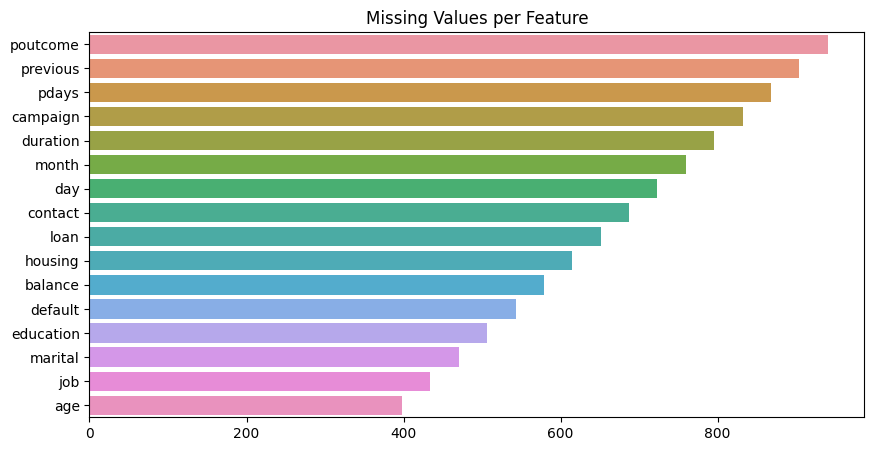

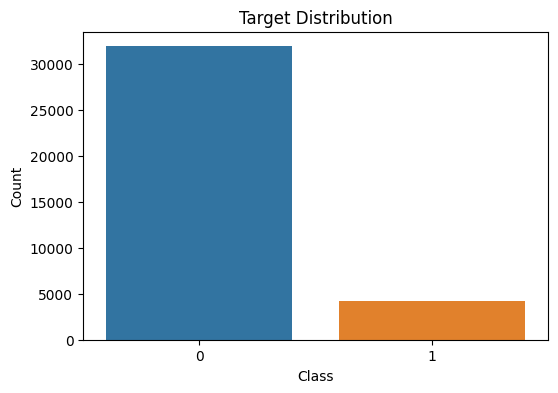

Class proportions:
y
0    0.883
1    0.117
Name: proportion, dtype: float64


In [ ]:
df_train = pd.read_csv("/kaggle/input/rka-ensemble-learning-challenge/train.csv")
df_test = pd.read_csv("/kaggle/input/rka-ensemble-learning-challenge/test.csv")

print("Dataset shape:", df_train.shape)
display(df_train.head(3))
df_train.info()

missing = df_train.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
plt.figure(figsize=(10,5))
sns.barplot(x=missing.values, y=missing.index)
plt.title("Missing Values per Feature")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x=df_train['y'])
plt.title("Target Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

print("Class proportions:")
print(df_train['y'].value_counts(normalize=True).round(3))


In [41]:
# === Feature Summary ===
num_cols = df_train.select_dtypes(include=['int64','float64']).columns
cat_cols = df_train.select_dtypes(include=['object']).columns

print(f"Numerical features: {len(num_cols)}")
print(f"Categorical features: {len(cat_cols)}")


Numerical features: 9
Categorical features: 9


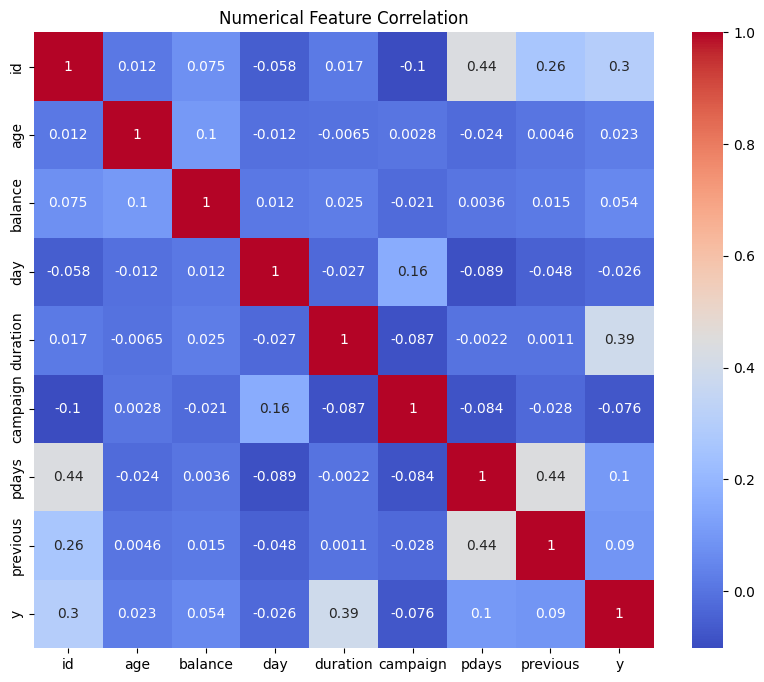

In [42]:
# === Correlation (Numerical) ===
plt.figure(figsize=(10,8))
corr = df_train[num_cols].corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title("Numerical Feature Correlation")
plt.show()


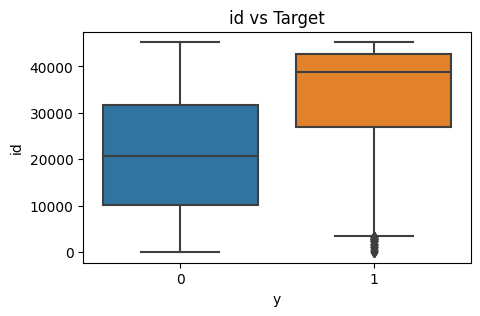

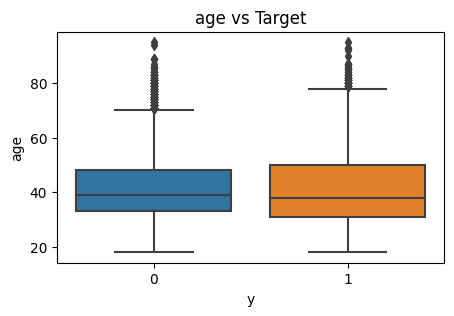

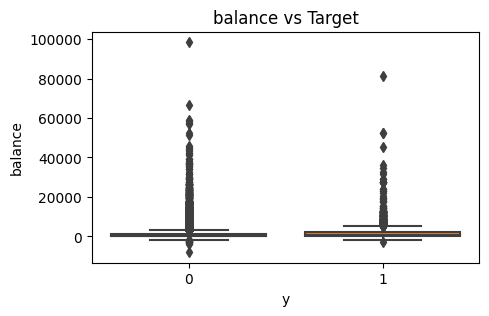

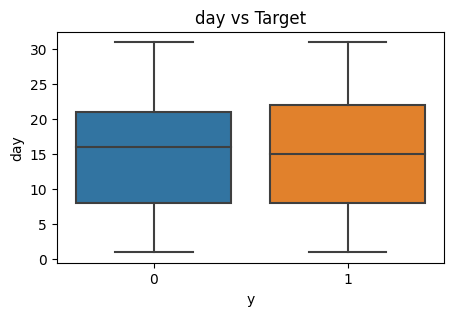

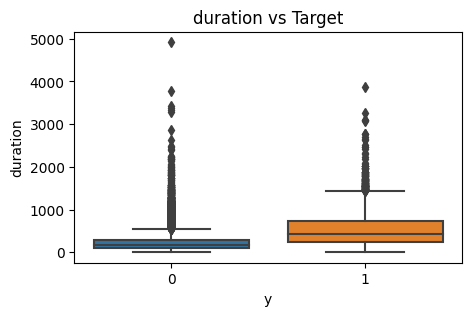

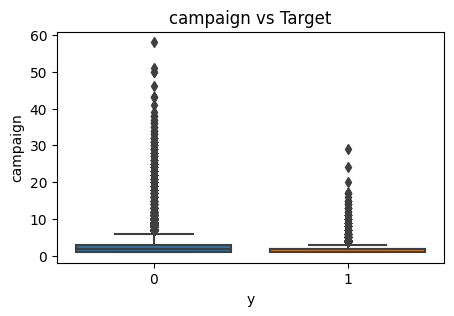

In [43]:
# === Numerical Features vs Target ===
for col in num_cols[:6]:
    plt.figure(figsize=(5,3))
    sns.boxplot(x='y', y=col, data=df_train)
    plt.title(f"{col} vs Target")
    plt.show()


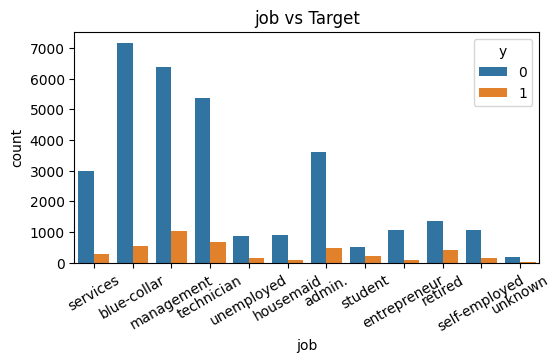

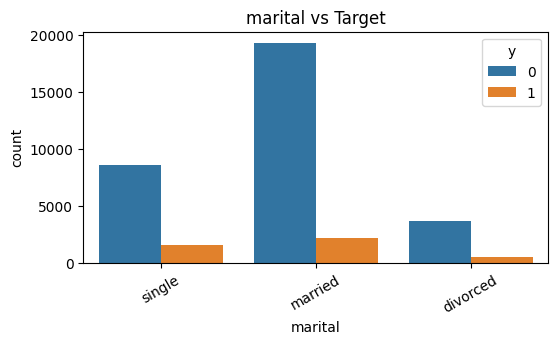

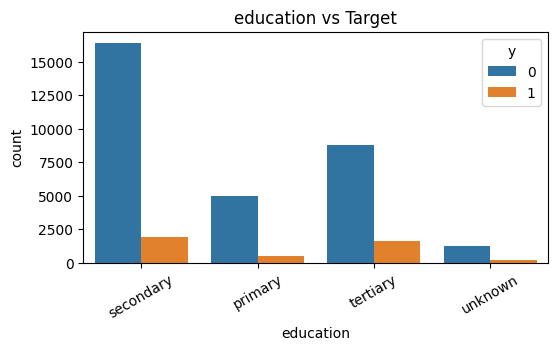

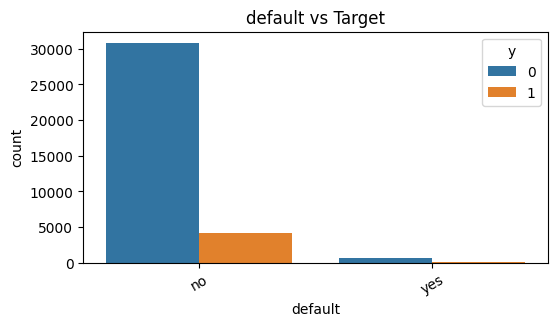

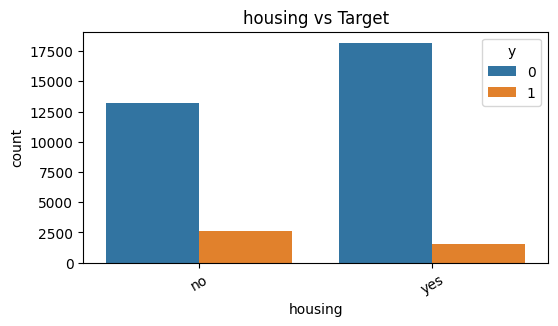

In [44]:
# === Categorical Features vs Target ===
for col in cat_cols[:5]:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, hue='y', data=df_train)
    plt.title(f"{col} vs Target")
    plt.xticks(rotation=30)
    plt.show()


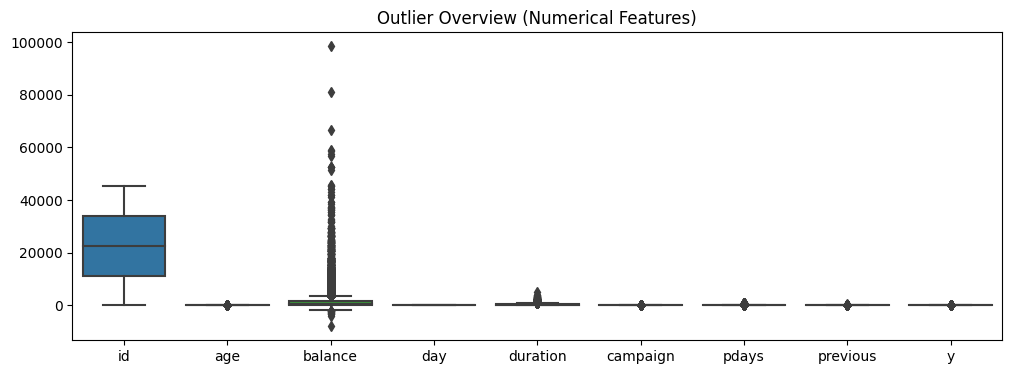

In [45]:
# === Outlier Detection ===
plt.figure(figsize=(12,4))
sns.boxplot(data=df_train[num_cols])
plt.title("Outlier Overview (Numerical Features)")
plt.show()


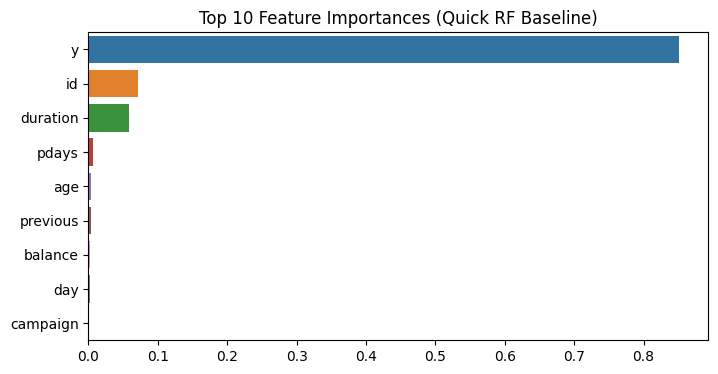

In [46]:
# === Quick Feature Importance (RF baseline) ===
le = LabelEncoder()
y_encoded = le.fit_transform(df_train['y'])

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(df_train[num_cols].fillna(0), y_encoded)

importances = pd.Series(rf.feature_importances_, index=num_cols).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=importances.values[:10], y=importances.index[:10])
plt.title("Top 10 Feature Importances (Quick RF Baseline)")
plt.show()


In [47]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
import joblib

def build_preprocessor(X):
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = X.select_dtypes(include=['object']).columns
    num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
    cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))])
    preprocessor = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)])
    return preprocessor

def build_base_models():
    models = {
        "logreg": LogisticRegression(max_iter=300, class_weight='balanced', C=0.7, solver='saga', n_jobs=-1),
        "rf": RandomForestClassifier(n_estimators=80, max_depth=6, min_samples_leaf=5, max_features='sqrt', random_state=42, class_weight='balanced', n_jobs=-1),
        "gb": GradientBoostingClassifier(n_estimators=150, learning_rate=0.03, max_depth=3, random_state=42)
    }
    return models

def get_oof_predictions(models, preprocessor, X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_preds = np.zeros((X.shape[0], len(models)))
    test_preds = np.zeros((df_test.shape[0], len(models)))
    for m_idx, (name, model) in enumerate(models.items()):
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            X_train_proc = preprocessor.fit_transform(X_train, y_train)
            X_val_proc = preprocessor.transform(X_val)
            sm = SMOTE(random_state=42)
            X_train_res, y_train_res = sm.fit_resample(X_train_proc, y_train)
            model.fit(X_train_res, y_train_res)
            oof_preds[val_idx, m_idx] = model.predict_proba(X_val_proc)[:, 1]
        pre_X_train = preprocessor.fit_transform(X, y)
        pre_X_test = preprocessor.transform(df_test.drop(columns=["id"]))
        model.fit(pre_X_train, y)
        test_preds[:, m_idx] = model.predict_proba(pre_X_test)[:, 1]
    return oof_preds, test_preds

def train_meta_model(oof_preds, y):
    meta_model = LogisticRegression(max_iter=500, solver='saga', C=1.0)
    meta_model.fit(oof_preds, y)
    return meta_model

def generate_submission(meta_model, test_preds, threshold=0.5):
    final_pred_proba = meta_model.predict_proba(test_preds)[:, 1]
    final_pred_label = (final_pred_proba >= threshold).astype(int)
    submission = pd.DataFrame({"id": df_test["id"], "y": final_pred_label})
    submission.to_csv("submission.csv", index=False)
    print("✅ Submission saved: submission.csv")

X = df_train.drop(columns=["id", "y"])
y = df_train["y"]
preprocessor = build_preprocessor(X)
models = build_base_models()
oof_preds, test_preds = get_oof_predictions(models, preprocessor, X, y, n_splits=10)
meta_model = train_meta_model(oof_preds, y)
generate_submission(meta_model, test_preds, threshold=0.1)


✅ Submission saved: submission.csv
